## Load the data in pickle file 

In [1]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


### Load the real observations

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [4]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

# Store Nan indices by taking maximum of nan coverage among the anomalies 

In [5]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        # for t in enumerate(range(time_period)[:2]):
            # print(np.where(np.isnan(dic_reduced_ssp585[m][i][t,:,:].ravel())==True))
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        # nan_idx_tmp_tt = list(np.where(np.isnan(dic_reduced_ssp585[m][i][1,:,:].ravel())==True)[0])
        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [6]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble

/tmp/ipykernel_21417/2788081108.py:17: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_21417/2788081108.py:19: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [7]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

## Now we can use the data to run some simple regression models

In [8]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

In [9]:
import torch 

# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    # variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)
    variance_processed_ssp585[m] = torch.mean(torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0))
    # variance_processed_ssp585[m] = torch.tensor(1.0)

### Define optimizaton problem with Pytorch

In [10]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train[m][i] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)

In [11]:
def ridge_estimator(model_out,x,y,vars,lambda_):
    """
    Compute the ridge estimator given gammas.
    """
    idx_start = 0
    for idx_m,m in enumerate(list(x.keys())):
        if m!= model_out:
            if idx_start==0:
                X_tmp = x[m]
                y_tmp = y[m]
                D = (1/vars[m])*torch.eye(x[m].shape[0])
                idx_start +=1
            else:
                X_tmp = torch.cat((X_tmp,x[m]),0)
                y_tmp = torch.cat((y_tmp,y[m]),0)
                D_tmp = ((1/vars[m]) * torch.eye(x[m].shape[0])).to(torch.float64)
                D = torch.block_diag(D, D_tmp).to(torch.float64)

    A = torch.matmul(torch.matmul(X_tmp.T, D),X_tmp) + lambda_ * torch.eye(X_tmp.shape[1])
    b = torch.matmul(torch.matmul(X_tmp.T,D),y_tmp)
    
    return torch.linalg.solve(A,b)

In [12]:
def train_ridge_regression(x,y,vars,lon_size,lat_size,models,lambda_,nbEpochs=100,verbose=True):
    """
    Given a model m, learn parameter β^m such that β^m = argmin_{β}(||y_m - X_m^T β||^2) ).

    Args:
        - x, y: training set and training target 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - lambda_: regularizer coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lat_size*lon_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-4)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0

    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
        
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        res = torch.zeros(len(models),33)

        
        for idx_m, m in enumerate(models):

            for idx_i, i in enumerate(x[m].keys()):
               
                
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i][:,notnan_idx],beta[notnan_idx]))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/len(x[m].keys())

        obj = torch.mean(res)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        if epoch < nbEpochs:
            training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch, 
                    ', loss=', loss.detach().item()
                    )

        criteria = loss
        epoch +=1
        

    plt.figure()
    plt.plot(range(nbEpochs)[:epoch],training_loss[:epoch])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()
    return beta.detach().clone()

In [13]:
def train_robust_model(x,y,vars,lon_size,lat_size,models,lambda_,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    # beta = torch.ones(lon_size*lat_size).to(torch.float64)
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-4)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
            
    # --- optimization loop ---                
    # while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):
    while (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        # obj = torch.tensor(0.0)
        # for m in models:
        #     obj += torch.exp((1/mu_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2)/vars[m])
        # obj = torch.tensor(0.0)
        # for m in models:
        #     obj += torch.exp((1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2)/vars[m])
    
        # obj = mu_*torch.log(obj)


        ######### Test #####################
        res = torch.zeros(len(models),33)

        for idx_m, m in enumerate(models):            
            for idx_i, i in enumerate(x[m].keys()):
                res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i][:,notnan_idx],beta[notnan_idx]))**2/vars[m]
            res[idx_m,:] = res[idx_m,:]/(len(x[m].keys()))

        obj = mu_*torch.logsumexp((1/mu_)* torch.mean(res,axis=1),0)
        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()              

        if(verbose==True):
            if(epoch % 2 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()

    # compute the alphas of the robust model
    M = len(x.keys())
    alpha = torch.zeros(M)
    res = torch.zeros(M,33)
    
    # compute the training loss for each model
    model_loss = torch.zeros(M)
    
    for idx_m,m in enumerate(x.keys()):
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
        model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    alpha = torch.nn.functional.softmax(alpha)
    
    return beta, alpha, model_loss

In [14]:
mu_ = 0.1
lambda_ = 100.0
# selected_models = list(dic_reduced_ssp585.keys())
# selected_models.remove('KACE-1-0-G')

# beta_robust, alpha_robust, model_loss = train_robust_model(x_train,y_train,variance_processed_ssp585,\
#                                       lat_size,lon_size,\
#                                       selected_models,\
#                                       lambda_,mu_,nbEpochs=100,verbose=True)


# beta_ridge = train_ridge_regression(x_train,y_train,variance_processed_ssp585,\
#                                     lat_size,lon_size,\
#                                     selected_models,\
#                                     lambda_,nbEpochs=300,verbose=True)

# print(model_loss)

In [15]:
# define beta to plot
# beta_ridge_tmp = beta_ridge.detach().clone()
# beta_ridge_tmp[nan_idx] = float('nan')
# beta_ridge_tmp = beta_ridge_tmp.detach().numpy().reshape(lat_size,lon.shape[0])

# # define robust beta
# beta_robust_tmp = beta_robust.detach().clone()
# beta_robust_tmp[nan_idx] = float('nan')
# beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

# fig0 = plt.figure(figsize=(16,16))           

# ax0 = fig0.add_subplot(2, 2, 1)        
# ax0.set_title(r'Ridge regression coefficient $\beta_{\mathrm{reg}}$', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_ridge_tmp,vmin=-0.00,vmax = 0.001)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(2, 2, 2)        
# ax1.set_title(r'Robust regression coefficient $\beta_{\mathrm{rob}}$', size=7,pad=3.0)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.001)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

# plt.show()

## Leave-one-out procedure

In [16]:
def compute_weights(x,y,vars,beta,lon_size,lat_size,models,mu_):
    """
    Plot and return the weights of the robust model.
    """
    M = len(list(dic_reduced_ssp585.keys()))
    alpha = torch.zeros(M)
    res = torch.zeros(M,33)
    
    for idx_m,m in enumerate(x.keys()):
        
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)

    alpha = torch.nn.functional.softmax(alpha)
    
    # plot the model contributions
    weights = {m: alpha[idx_m].item() for idx_m,m in enumerate(models)}

    return weights

In [17]:
def leave_one_out(model_out,x,y,vars,lon_size,lat_size,lambda_,method='robust',mu_=1.0,nbEpochs=500,verbose=True):

    # Data preprocessing
    x_train = {}
    y_train = {}

    x_test = {}
    y_test = {}
    selected_models = []

    for idx_m,m in enumerate(x.keys()):
        if m != model_out:

            x_train[m] = {}
            y_train[m] = {}
            
            # selected models 
            selected_models.append(m)
            
            for idx_i, i in enumerate(x[m].keys()):
                
                
                x_train[m][i] = torch.from_numpy(np.nan_to_num(x[m][i]).reshape(x[m][i].shape[0],lon_size*lat_size)).to(torch.float64)
                y_train[m][i] = torch.from_numpy(y[m][i]).to(torch.float64)
        
        else:
            for idx_i, i in enumerate(x[model_out].keys()):
                x_test[i] = np.nan_to_num(x[model_out][i]).reshape(x[model_out][i].shape[0],lon_size*lat_size)            
                y_test[i] = y[model_out][i]

    # if method = robust, then we train the robust
    if method == 'robust':
        beta, alpha, model_loss = train_robust_model(x_train,y_train,vars,\
                                    lon_size,lat_size,\
                                    selected_models,\
                                    lambda_,mu_,nbEpochs,verbose)

    else:
        beta = train_ridge_regression(x_train,y_train,vars,\
                                        lon_size,lat_size,\
                                        selected_models,\
                                        lambda_,nbEpochs,verbose)

    y_pred={}
    for idx_i, i in enumerate(x[model_out].keys()):
        y_pred[i] = np.dot(x_test[i],beta.detach().numpy())

    if method == 'robust':
        weights = compute_weights(x_train,y_train,vars,beta,lon_size,lat_size,selected_models,mu_)
    else:
        weights = {m: (1/len(x.keys())) for m in x.keys()}

    return beta, y_pred, y_test, weights

In [18]:
# m = 'KACE-1-0-G'
# lambda_ = 400.0
# mu_ = 0.5
# beta, y_pred, y_test, weights = leave_one_out(m,x_predictor,y_forced_response,variance_processed_ssp585,\
#                                               lon_size,lat_size,lambda_,\
#                                               method='robust',mu_=mu_,\
#                                               nbEpochs=300,verbose=True)

# rmse_tmp = 0.0
# for idx_r, r in enumerate(x_predictor[m].keys()):
#     rmse_tmp += torch.mean((y_pred[r] - y_test[r])**2/variance_processed_ssp585[m])
# rmse_tmp = rmse_tmp/len(x_predictor[m].keys())
# print(rmse_tmp)

In [19]:
def leave_one_out_procedure(x,y,vars,lon_size,lat_size,lambda_,method='robust',mu_=1.0,nbEpochs=500,verbose=True):

    beta = {}
    y_pred = {}
    y_test = {}
    rmse = {}
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):
        
        beta[m], y_pred[m], y_test[m], weights_tmp = leave_one_out(m,x,y,vars,lon_size,lat_size,lambda_,method,mu_,nbEpochs,verbose)

        rmse[m] = 0
        for idx_i, i in enumerate(x[m].keys()):
            rmse[m] += np.mean((y_test[m][i] - y_pred[m][i])**2)/vars[m]
        rmse[m] = rmse[m]/len(x[m].keys())
            
        # compute the weight when a single model is out 
        if method == 'robust':    
            for m_tmp in list(x.keys()):
                if m_tmp != m:
                    weights[m_tmp] += (1/(len(x.keys())-1))* weights_tmp[m_tmp]

        # print the rmse
        print('RMSE on model ', m, ' : ', rmse[m])

    print("Check that the weights sum to 1.0 ",np.sum(np.array(list(weights.values()))))
    ################# plot the observation vs prediction accuracy #####################################
    # fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    # fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    # axs = axs.ravel()
    
    # for idx_m, m in enumerate(x.keys()):
        
    #     # create the function y=x
    #     minx = np.min(y_test[m])
    #     maxx = np.max(y_test[m])
    #     x_tmp = np.linspace(minx,maxx,100)
    #     y_tmp = x_tmp

    #     axs[idx_m].scatter(y_test[m],y_pred[m],label=m,s=0.1)
    #     axs[idx_m].plot(x_tmp,y_tmp,color='r',linewidth=0.5)
    #     axs[idx_m].set_title(m)

    # for i in range(len(x.keys()),30):
    #     fig.delaxes(axs[i])

    # fig.tight_layout()
    # plt.savefig("results/pred_vs_real_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    # plt.show()

    # ############################### plot the residuals #####################################
    # fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    # fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    # axs = axs.ravel()
    
    # for idx_m, m in enumerate(x.keys()):

    #     axs[idx_m].scatter(y_test[m],y_test[m] - y_pred[m],label=m,s=0.1)
    #     axs[idx_m].plot(x_tmp,np.zeros_like(x_tmp),color='r',linewidth=0.5)
    #     axs[idx_m].set_title(m)

    # for i in range(len(x.keys()),30):
    #     fig.delaxes(axs[i])

    # fig.tight_layout()
    # plt.savefig("results/residuals_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    # plt.show()
    
    # ############## plot the beta map for each leave-one-out run #####################################
    # fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    # fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    # axs = axs.ravel()
    
    # for idx_m, m in enumerate(x.keys()):
        
    #     beta_tmp = beta[m].detach().clone()
    #     beta_tmp[nans_idx] = float('nan')
    #     beta_tmp = beta_tmp.detach().numpy().reshape(lat_size,lon_size)

    #     axs[idx_m].set_title(m)
    #     im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.005)

    # plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    # for i in range(len(x.keys()),30):
    #     fig.delaxes(axs[i])

    # fig.tight_layout()
    # plt.savefig("results/beta_map_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    # plt.show()

    
    ################# plot the weights #################
    if method == 'robust':    
        fig, ax = plt.subplots()
        models = list(x.keys()) 
        weights_plot = list(weights.values()) 
        ax.bar(models, weights_plot,label='Model weights')
        ax.set_ylabel(r'weights $\gamma$')
        ax.set_title('cmip6 models')
        ax.legend()
        ax.set_xticklabels(models, rotation=-90)
        plt.tight_layout()
        plt.savefig("results/weights_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
        plt.show()

    ################# plot the rmse #################
    fig, ax = plt.subplots()
    models = list(x.keys()) 
    rmse_plot = list(rmse.values()) 
    ax.bar(models, rmse_plot,label='rmse')
    ax.set_ylabel(r'LOO')
    ax.set_title('LOO rmse')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.savefig("results/rmse_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return beta, rmse, weights

Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7194879055023193
Epoch  6 , loss= 1.18344247341156
Epoch  8 , loss= 1.4116257429122925
Epoch  10 , loss= 1.9973801374435425
Epoch  12 , loss= 2.5412092208862305
Epoch  14 , loss= 2.4210915565490723
Epoch  16 , loss= 1.8552191257476807
Epoch  18 , loss= 1.4469330310821533
Epoch  20 , loss= 1.2391221523284912
Epoch  22 , loss= 1.1260789632797241
Epoch  24 , loss= 1.1816476583480835
Epoch  26 , loss= 1.2639120817184448
Epoch  28 , loss= 1.2107758522033691
Epoch  30 , loss= 1.0964726209640503
Epoch  32 , loss= 1.022572636604309
Epoch  34 , loss= 0.9993587136268616
Epoch  36 , loss= 1.0055298805236816
Epoch  38 , loss= 1.0207042694091797
Epoch  40 , loss= 1.0310887098312378
Epoch  42 , loss= 1.0301971435546875
Epoch  44 , loss= 1.0183453559875488
Epoch  46 , loss= 1.0003485679626465
Epoch  48 , loss= 0.9822181463241577
Epoch  50 , loss= 0.9686206579208374
Epoch  52 , loss= 0.9613861441612244
Epoch  54

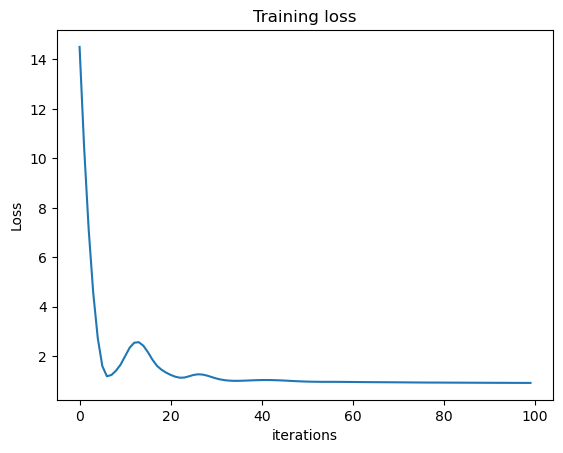

/tmp/ipykernel_21417/2249715007.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)
/tmp/ipykernel_21417/3968403812.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


RMSE on model  CanESM5-1  :  tensor(0.6551, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1907212734222412
Epoch  8 , loss= 1.411205530166626
Epoch  10 , loss= 1.997907280921936
Epoch  12 , loss= 2.537914752960205
Epoch  14 , loss= 2.422374725341797
Epoch  16 , loss= 1.8621724843978882
Epoch  18 , loss= 1.449238657951355
Epoch  20 , loss= 1.2388278245925903
Epoch  22 , loss= 1.1278101205825806
Epoch  24 , loss= 1.1880552768707275
Epoch  26 , loss= 1.2664117813110352
Epoch  28 , loss= 1.2101877927780151
Epoch  30 , loss= 1.0978498458862305
Epoch  32 , loss= 1.0262196063995361
Epoch  34 , loss= 1.0037195682525635
Epoch  36 , loss= 1.0101968050003052
Epoch  38 , loss= 1.0256118774414062
Epoch  40 , loss= 1.0361206531524658
Epoch  42 , loss= 1.035294532775879
Epoch  44 , loss= 1.023530125617981
Epoch  46 , loss= 1.0055980682373047
Epoch  48 , loss= 0.9874208569526672
Epoch  50 , loss= 0.97

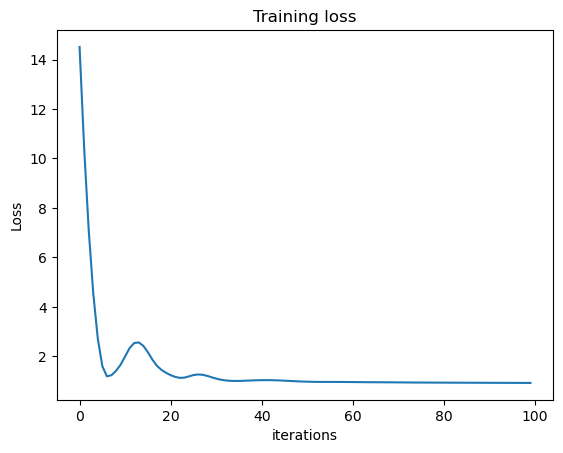

RMSE on model  CNRM-ESM2-1  :  tensor(0.4576, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7173256874084473
Epoch  6 , loss= 1.1749824285507202
Epoch  8 , loss= 1.4089672565460205
Epoch  10 , loss= 1.9931925535202026
Epoch  12 , loss= 2.5367138385772705
Epoch  14 , loss= 2.4184186458587646
Epoch  16 , loss= 1.8537718057632446
Epoch  18 , loss= 1.4434378147125244
Epoch  20 , loss= 1.2341052293777466
Epoch  22 , loss= 1.1028494834899902
Epoch  24 , loss= 1.077915906906128
Epoch  26 , loss= 1.1508454084396362
Epoch  28 , loss= 1.2209975719451904
Epoch  30 , loss= 1.2169522047042847
Epoch  32 , loss= 1.1440106630325317
Epoch  34 , loss= 1.0535794496536255
Epoch  36 , loss= 0.9937984347343445
Epoch  38 , loss= 0.9781734347343445
Epoch  40 , loss= 0.9883481860160828
Epoch  42 , loss= 1.0024949312210083
Epoch  44 , loss= 1.0088746547698975
Epoch  46 , loss= 1.0044074058532715
Epoch  48 , loss= 0.9914253950119019
Epoch  50 , lo

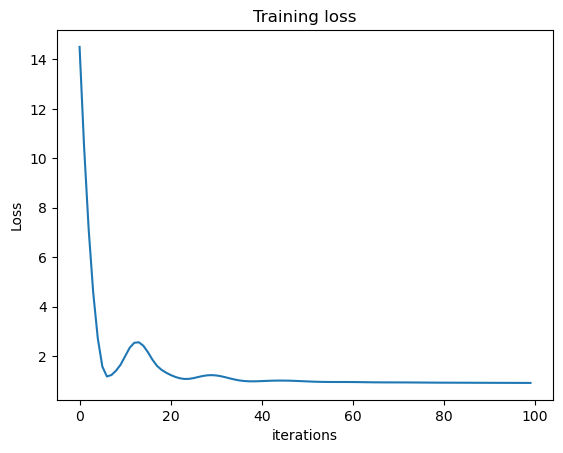

RMSE on model  FIO-ESM-2-0  :  tensor(0.7701, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1907716989517212
Epoch  8 , loss= 1.413766860961914
Epoch  10 , loss= 2.001784563064575
Epoch  12 , loss= 2.5430829524993896
Epoch  14 , loss= 2.4264721870422363
Epoch  16 , loss= 1.8641427755355835
Epoch  18 , loss= 1.4515893459320068
Epoch  20 , loss= 1.241782307624817
Epoch  22 , loss= 1.1285364627838135
Epoch  24 , loss= 1.1848212480545044
Epoch  26 , loss= 1.2670331001281738
Epoch  28 , loss= 1.213827133178711
Epoch  30 , loss= 1.100780963897705
Epoch  32 , loss= 1.0279954671859741
Epoch  34 , loss= 1.0046569108963013
Epoch  36 , loss= 1.0103923082351685
Epoch  38 , loss= 1.0253946781158447
Epoch  40 , loss= 1.0360311269760132
Epoch  42 , loss= 1.0358211994171143
Epoch  44 , loss= 1.024834156036377
Epoch  46 , loss= 1.0074803829193115
Epoch  48 , loss= 0.9894941449165344
Epoch  50 , loss= 0

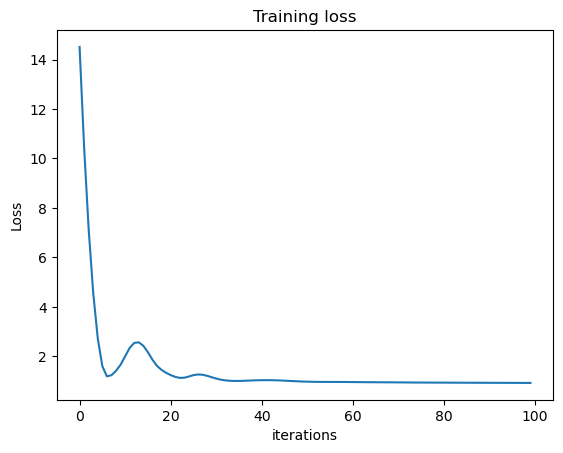

RMSE on model  GISS-E2-2-G  :  tensor(0.3372, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1899195909500122
Epoch  8 , loss= 1.4122179746627808
Epoch  10 , loss= 1.9988678693771362
Epoch  12 , loss= 2.539376735687256
Epoch  14 , loss= 2.423520565032959
Epoch  16 , loss= 1.8627910614013672
Epoch  18 , loss= 1.451220154762268
Epoch  20 , loss= 1.2416402101516724
Epoch  22 , loss= 1.1290004253387451
Epoch  24 , loss= 1.1866735219955444
Epoch  26 , loss= 1.2659376859664917
Epoch  28 , loss= 1.2102582454681396
Epoch  30 , loss= 1.097252368927002
Epoch  32 , loss= 1.025170087814331
Epoch  34 , loss= 1.0025192499160767
Epoch  36 , loss= 1.0089575052261353
Epoch  38 , loss= 1.0244182348251343
Epoch  40 , loss= 1.0349922180175781
Epoch  42 , loss= 1.0341843366622925
Epoch  44 , loss= 1.0223816633224487
Epoch  46 , loss= 1.0043917894363403
Epoch  48 , loss= 0.9861707091331482
Epoch  50 , loss= 

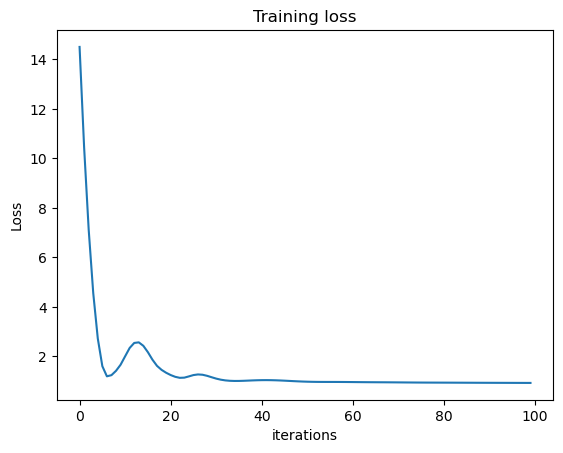

RMSE on model  CNRM-CM6-1  :  tensor(0.5171, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1907434463500977
Epoch  8 , loss= 1.4137821197509766
Epoch  10 , loss= 2.000520706176758
Epoch  12 , loss= 2.5416066646575928
Epoch  14 , loss= 2.425487756729126
Epoch  16 , loss= 1.8640048503875732
Epoch  18 , loss= 1.452168583869934
Epoch  20 , loss= 1.2424441576004028
Epoch  22 , loss= 1.1293649673461914
Epoch  24 , loss= 1.1858757734298706
Epoch  26 , loss= 1.2668873071670532
Epoch  28 , loss= 1.212610125541687
Epoch  30 , loss= 1.0996228456497192
Epoch  32 , loss= 1.0273947715759277
Epoch  34 , loss= 1.0044037103652954
Epoch  36 , loss= 1.0102735757827759
Epoch  38 , loss= 1.0253328084945679
Epoch  40 , loss= 1.0359749794006348
Epoch  42 , loss= 1.0356879234313965
Epoch  44 , loss= 1.0245662927627563
Epoch  46 , loss= 1.007096290588379
Epoch  48 , loss= 0.9890639185905457
Epoch  50 , loss= 0

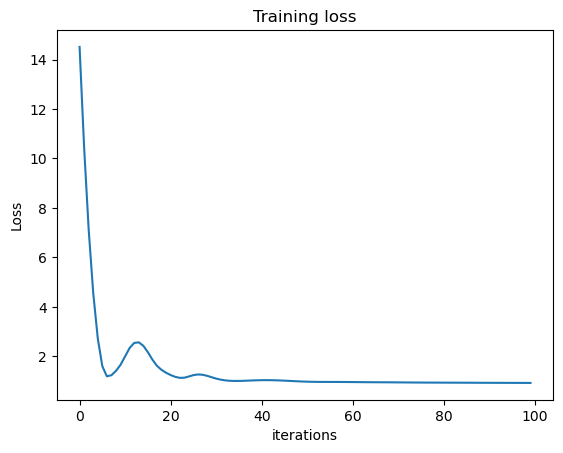

RMSE on model  MIROC-ES2L  :  tensor(0.3789, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196028232574463
Epoch  6 , loss= 1.1864898204803467
Epoch  8 , loss= 1.4090951681137085
Epoch  10 , loss= 1.996451497077942
Epoch  12 , loss= 2.5363922119140625
Epoch  14 , loss= 2.4194984436035156
Epoch  16 , loss= 1.8573198318481445
Epoch  18 , loss= 1.444236397743225
Epoch  20 , loss= 1.2351136207580566
Epoch  22 , loss= 1.1206506490707397
Epoch  24 , loss= 1.1824841499328613
Epoch  26 , loss= 1.2586640119552612
Epoch  28 , loss= 1.196980595588684
Epoch  30 , loss= 1.0817474126815796
Epoch  32 , loss= 1.0124531984329224
Epoch  34 , loss= 0.9940934777259827
Epoch  36 , loss= 1.0032098293304443
Epoch  38 , loss= 1.0193631649017334
Epoch  40 , loss= 1.0294508934020996
Epoch  42 , loss= 1.027878999710083
Epoch  44 , loss= 1.015652060508728
Epoch  46 , loss= 0.9977681040763855
Epoch  48 , loss= 0.9800536036491394
Epoch  50 , loss= 0

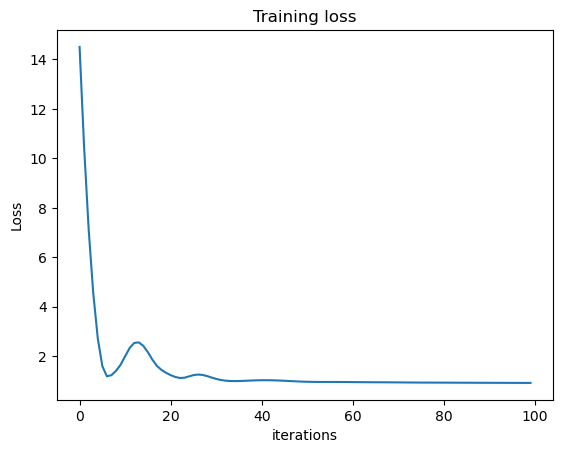

RMSE on model  HadGEM3-GC31-MM  :  tensor(0.6696, dtype=torch.float64)
Epoch  0 , loss= 11.574769020080566
Epoch  2 , loss= 5.706143856048584
Epoch  4 , loss= 2.2898716926574707
Epoch  6 , loss= 1.1840310096740723
Epoch  8 , loss= 1.4116238355636597
Epoch  10 , loss= 1.857417345046997
Epoch  12 , loss= 2.209437370300293
Epoch  14 , loss= 2.1369869709014893
Epoch  16 , loss= 1.7646573781967163
Epoch  18 , loss= 1.439478874206543
Epoch  20 , loss= 1.2196241617202759
Epoch  22 , loss= 1.065900444984436
Epoch  24 , loss= 1.0306845903396606
Epoch  26 , loss= 1.1263405084609985
Epoch  28 , loss= 1.2074086666107178
Epoch  30 , loss= 1.1864389181137085
Epoch  32 , loss= 1.089243769645691
Epoch  34 , loss= 0.9976614713668823
Epoch  36 , loss= 0.9685118198394775
Epoch  38 , loss= 0.9842938780784607
Epoch  40 , loss= 1.0052989721298218
Epoch  42 , loss= 1.0124012231826782
Epoch  44 , loss= 1.0028043985366821
Epoch  46 , loss= 0.9825697541236877
Epoch  48 , loss= 0.9620623588562012
Epoch  50 , los

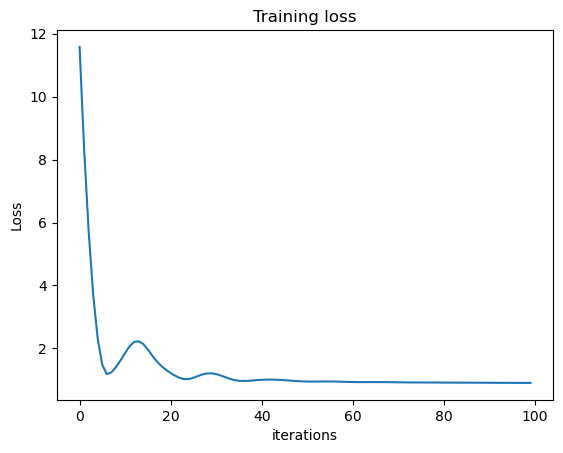

RMSE on model  CanESM5-CanOE  :  tensor(0.7293, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.19065523147583
Epoch  8 , loss= 1.4109504222869873
Epoch  10 , loss= 1.9974435567855835
Epoch  12 , loss= 2.5372159481048584
Epoch  14 , loss= 2.421640157699585
Epoch  16 , loss= 1.8611369132995605
Epoch  18 , loss= 1.446537733078003
Epoch  20 , loss= 1.2371259927749634
Epoch  22 , loss= 1.1275451183319092
Epoch  24 , loss= 1.1883981227874756
Epoch  26 , loss= 1.2657133340835571
Epoch  28 , loss= 1.2081526517868042
Epoch  30 , loss= 1.0954827070236206
Epoch  32 , loss= 1.0244914293289185
Epoch  34 , loss= 1.0026010274887085
Epoch  36 , loss= 1.0093848705291748
Epoch  38 , loss= 1.0248701572418213
Epoch  40 , loss= 1.0352534055709839
Epoch  42 , loss= 1.0341767072677612
Epoch  44 , loss= 1.0221588611602783
Epoch  46 , loss= 1.0040743350982666
Epoch  48 , loss= 0.9858821630477905
Epoch  50 , los

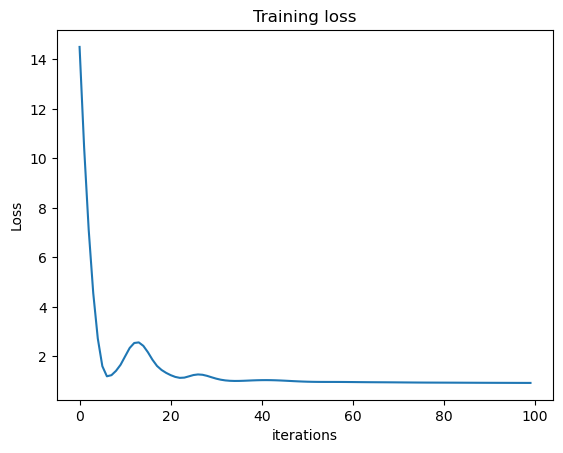

RMSE on model  EC-Earth3  :  tensor(0.5199, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.719447374343872
Epoch  6 , loss= 1.184199571609497
Epoch  8 , loss= 1.410665512084961
Epoch  10 , loss= 1.9912235736846924
Epoch  12 , loss= 2.5329015254974365
Epoch  14 , loss= 2.4134747982025146
Epoch  16 , loss= 1.843812346458435
Epoch  18 , loss= 1.4450315237045288
Epoch  20 , loss= 1.2433102130889893
Epoch  22 , loss= 1.1300359964370728
Epoch  24 , loss= 1.1830558776855469
Epoch  26 , loss= 1.2560521364212036
Epoch  28 , loss= 1.1916571855545044
Epoch  30 , loss= 1.0760371685028076
Epoch  32 , loss= 1.014200210571289
Epoch  34 , loss= 0.9995410442352295
Epoch  36 , loss= 1.0073190927505493
Epoch  38 , loss= 1.0209987163543701
Epoch  40 , loss= 1.0295597314834595
Epoch  42 , loss= 1.0278260707855225
Epoch  44 , loss= 1.016405701637268
Epoch  46 , loss= 0.9995929002761841
Epoch  48 , loss= 0.9824867248535156
Epoch  50 , loss= 0.9

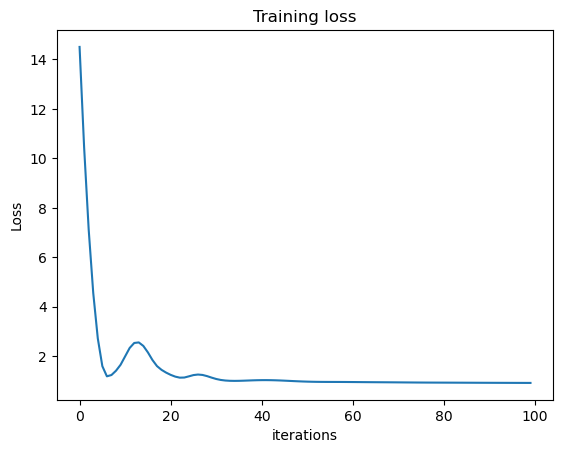

RMSE on model  KACE-1-0-G  :  tensor(0.7413, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1908220052719116
Epoch  8 , loss= 1.4093046188354492
Epoch  10 , loss= 1.9967966079711914
Epoch  12 , loss= 2.5358452796936035
Epoch  14 , loss= 2.420346736907959
Epoch  16 , loss= 1.8604987859725952
Epoch  18 , loss= 1.4437223672866821
Epoch  20 , loss= 1.232827067375183
Epoch  22 , loss= 1.1253597736358643
Epoch  24 , loss= 1.1868159770965576
Epoch  26 , loss= 1.261560082435608
Epoch  28 , loss= 1.204013705253601
Epoch  30 , loss= 1.093732476234436
Epoch  32 , loss= 1.0242680311203003
Epoch  34 , loss= 1.001854658126831
Epoch  36 , loss= 1.0076141357421875
Epoch  38 , loss= 1.022578239440918
Epoch  40 , loss= 1.0328892469406128
Epoch  42 , loss= 1.0319145917892456
Epoch  44 , loss= 1.0200352668762207
Epoch  46 , loss= 1.002057433128357
Epoch  48 , loss= 0.9838694334030151
Epoch  50 , loss= 0.97

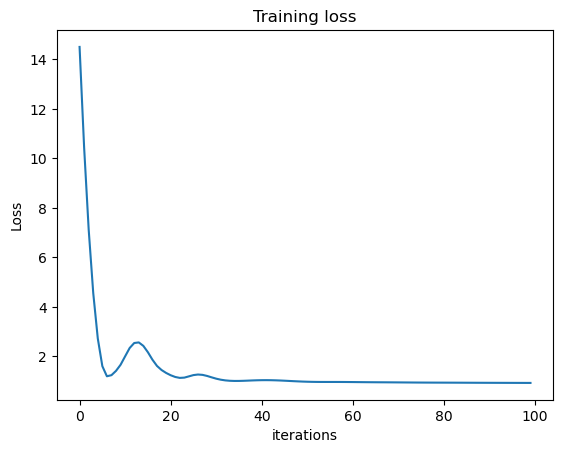

RMSE on model  GISS-E2-1-H  :  tensor(0.5536, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1904551982879639
Epoch  8 , loss= 1.411575198173523
Epoch  10 , loss= 1.9979380369186401
Epoch  12 , loss= 2.5381171703338623
Epoch  14 , loss= 2.422476053237915
Epoch  16 , loss= 1.8619588613510132
Epoch  18 , loss= 1.4497607946395874
Epoch  20 , loss= 1.24019455909729
Epoch  22 , loss= 1.1284217834472656
Epoch  24 , loss= 1.1873668432235718
Epoch  26 , loss= 1.2660855054855347
Epoch  28 , loss= 1.209892988204956
Epoch  30 , loss= 1.0971630811691284
Epoch  32 , loss= 1.025394082069397
Epoch  34 , loss= 1.0029648542404175
Epoch  36 , loss= 1.0095502138137817
Epoch  38 , loss= 1.0250358581542969
Epoch  40 , loss= 1.0355559587478638
Epoch  42 , loss= 1.0346943140029907
Epoch  44 , loss= 1.0228793621063232
Epoch  46 , loss= 1.0049129724502563
Epoch  48 , loss= 0.98673415184021
Epoch  50 , loss= 0.9

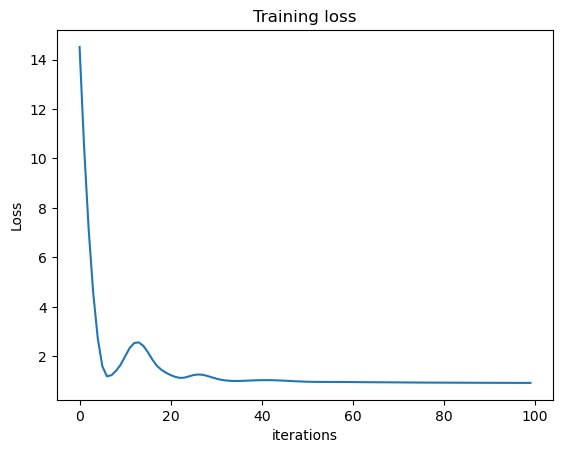

RMSE on model  EC-Earth3-Veg  :  tensor(0.4778, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.719602108001709
Epoch  6 , loss= 1.1874589920043945
Epoch  8 , loss= 1.412275791168213
Epoch  10 , loss= 1.9980666637420654
Epoch  12 , loss= 2.5388171672821045
Epoch  14 , loss= 2.422746181488037
Epoch  16 , loss= 1.861989974975586
Epoch  18 , loss= 1.4513211250305176
Epoch  20 , loss= 1.2421762943267822
Epoch  22 , loss= 1.1291033029556274
Epoch  24 , loss= 1.185898780822754
Epoch  26 , loss= 1.2650810480117798
Epoch  28 , loss= 1.2084163427352905
Epoch  30 , loss= 1.0939879417419434
Epoch  32 , loss= 1.0219998359680176
Epoch  34 , loss= 1.000361680984497
Epoch  36 , loss= 1.007428765296936
Epoch  38 , loss= 1.0229432582855225
Epoch  40 , loss= 1.0332515239715576
Epoch  42 , loss= 1.0321016311645508
Epoch  44 , loss= 1.0200515985488892
Epoch  46 , loss= 1.0019874572753906
Epoch  48 , loss= 0.9838377833366394
Epoch  50 , loss= 

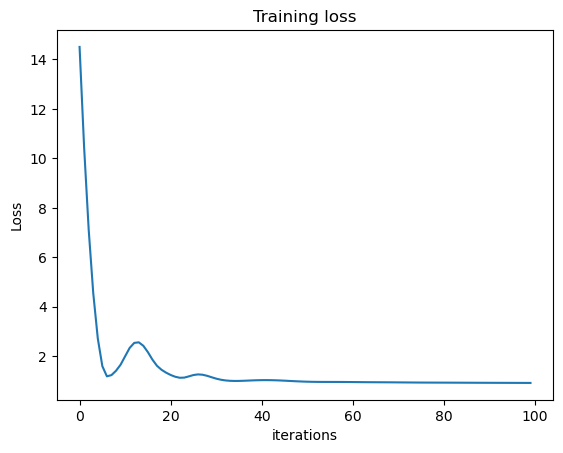

RMSE on model  HadGEM3-GC31-LL  :  tensor(0.5832, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1909607648849487
Epoch  8 , loss= 1.413527250289917
Epoch  10 , loss= 2.0010573863983154
Epoch  12 , loss= 2.5422184467315674
Epoch  14 , loss= 2.425870895385742
Epoch  16 , loss= 1.8640283346176147
Epoch  18 , loss= 1.4519201517105103
Epoch  20 , loss= 1.2421605587005615
Epoch  22 , loss= 1.1289337873458862
Epoch  24 , loss= 1.185232400894165
Epoch  26 , loss= 1.2668182849884033
Epoch  28 , loss= 1.2130348682403564
Epoch  30 , loss= 1.1000438928604126
Epoch  32 , loss= 1.0276647806167603
Epoch  34 , loss= 1.0045753717422485
Epoch  36 , loss= 1.0103096961975098
Epoch  38 , loss= 1.0251781940460205
Epoch  40 , loss= 1.0357109308242798
Epoch  42 , loss= 1.035538673400879
Epoch  44 , loss= 1.0247178077697754
Epoch  46 , loss= 1.0075465440750122
Epoch  48 , loss= 0.9896410703659058
Epoch  50 , l

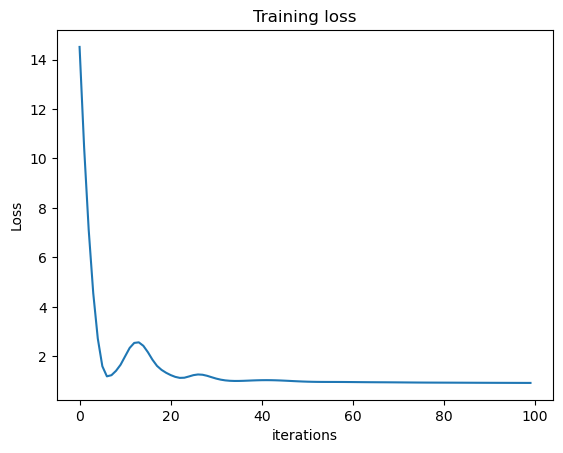

RMSE on model  MIROC6  :  tensor(0.3456, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1892492771148682
Epoch  8 , loss= 1.413627028465271
Epoch  10 , loss= 2.001399040222168
Epoch  12 , loss= 2.5425360202789307
Epoch  14 , loss= 2.425788164138794
Epoch  16 , loss= 1.8636348247528076
Epoch  18 , loss= 1.4514693021774292
Epoch  20 , loss= 1.2416759729385376
Epoch  22 , loss= 1.127913236618042
Epoch  24 , loss= 1.1837824583053589
Epoch  26 , loss= 1.2661513090133667
Epoch  28 , loss= 1.2128885984420776
Epoch  30 , loss= 1.0995663404464722
Epoch  32 , loss= 1.0264849662780762
Epoch  34 , loss= 1.0028588771820068
Epoch  36 , loss= 1.0082652568817139
Epoch  38 , loss= 1.0229402780532837
Epoch  40 , loss= 1.0334200859069824
Epoch  42 , loss= 1.0333553552627563
Epoch  44 , loss= 1.0227493047714233
Epoch  46 , loss= 1.0058237314224243
Epoch  48 , loss= 0.9881656765937805
Epoch  50 , loss= 0.97

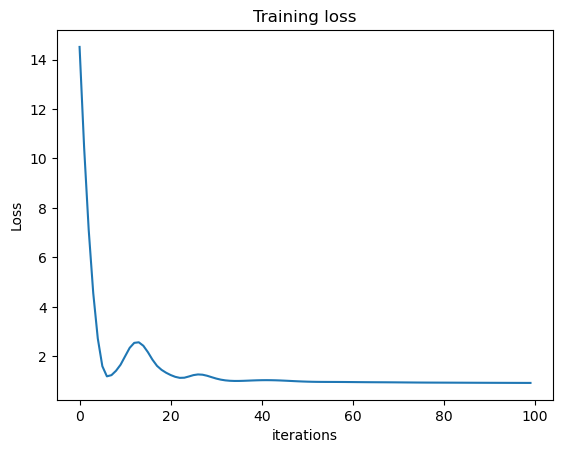

RMSE on model  CESM2  :  tensor(0.5006, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196028232574463
Epoch  6 , loss= 1.1861283779144287
Epoch  8 , loss= 1.4083765745162964
Epoch  10 , loss= 1.9971213340759277
Epoch  12 , loss= 2.537360429763794
Epoch  14 , loss= 2.419800281524658
Epoch  16 , loss= 1.8582243919372559
Epoch  18 , loss= 1.4468456506729126
Epoch  20 , loss= 1.2378102540969849
Epoch  22 , loss= 1.1231316328048706
Epoch  24 , loss= 1.1829768419265747
Epoch  26 , loss= 1.262385368347168
Epoch  28 , loss= 1.2029510736465454
Epoch  30 , loss= 1.0854544639587402
Epoch  32 , loss= 1.0130198001861572
Epoch  34 , loss= 0.9939179420471191
Epoch  36 , loss= 1.0034573078155518
Epoch  38 , loss= 1.0200567245483398
Epoch  40 , loss= 1.0303552150726318
Epoch  42 , loss= 1.0287660360336304
Epoch  44 , loss= 1.0163522958755493
Epoch  46 , loss= 0.9982417821884155
Epoch  48 , loss= 0.9804175496101379
Epoch  50 , loss= 0.96

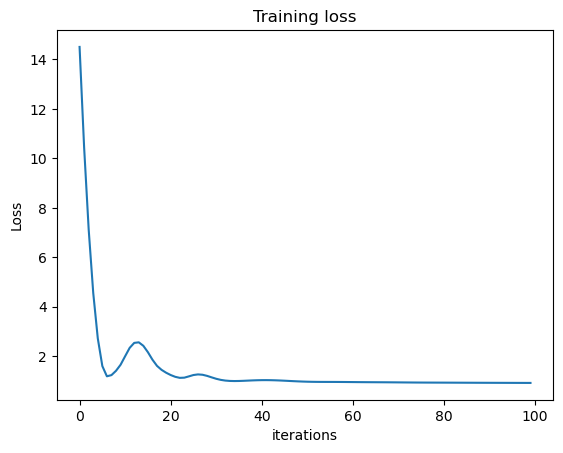

RMSE on model  FGOALS-g3  :  tensor(0.6594, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1904939413070679
Epoch  8 , loss= 1.4055230617523193
Epoch  10 , loss= 1.9945343732833862
Epoch  12 , loss= 2.531480550765991
Epoch  14 , loss= 2.415479898452759
Epoch  16 , loss= 1.8537386655807495
Epoch  18 , loss= 1.406148910522461
Epoch  20 , loss= 1.185127854347229
Epoch  22 , loss= 1.105128526687622
Epoch  24 , loss= 1.1846730709075928
Epoch  26 , loss= 1.245837926864624
Epoch  28 , loss= 1.1819239854812622
Epoch  30 , loss= 1.0767990350723267
Epoch  32 , loss= 1.0107110738754272
Epoch  34 , loss= 0.9881304502487183
Epoch  36 , loss= 0.9928095936775208
Epoch  38 , loss= 1.0066959857940674
Epoch  40 , loss= 1.0156151056289673
Epoch  42 , loss= 1.0127315521240234
Epoch  44 , loss= 0.998802125453949
Epoch  46 , loss= 0.9791873097419739
Epoch  48 , loss= 0.960091769695282
Epoch  50 , loss= 0.946

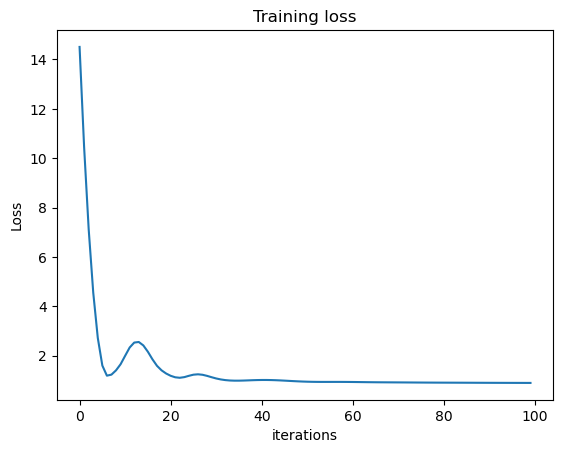

RMSE on model  GISS-E2-1-G  :  tensor(0.7959, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.190139651298523
Epoch  8 , loss= 1.4112492799758911
Epoch  10 , loss= 1.9986473321914673
Epoch  12 , loss= 2.5389575958251953
Epoch  14 , loss= 2.4228389263153076
Epoch  16 , loss= 1.8616052865982056
Epoch  18 , loss= 1.4485902786254883
Epoch  20 , loss= 1.239210605621338
Epoch  22 , loss= 1.1273765563964844
Epoch  24 , loss= 1.1859474182128906
Epoch  26 , loss= 1.264585018157959
Epoch  28 , loss= 1.2086814641952515
Epoch  30 , loss= 1.0962750911712646
Epoch  32 , loss= 1.0246543884277344
Epoch  34 , loss= 1.0017502307891846
Epoch  36 , loss= 1.007655143737793
Epoch  38 , loss= 1.0227493047714233
Epoch  40 , loss= 1.0332293510437012
Epoch  42 , loss= 1.0325191020965576
Epoch  44 , loss= 1.0208901166915894
Epoch  46 , loss= 1.0030503273010254
Epoch  48 , loss= 0.984870433807373
Epoch  50 , loss= 

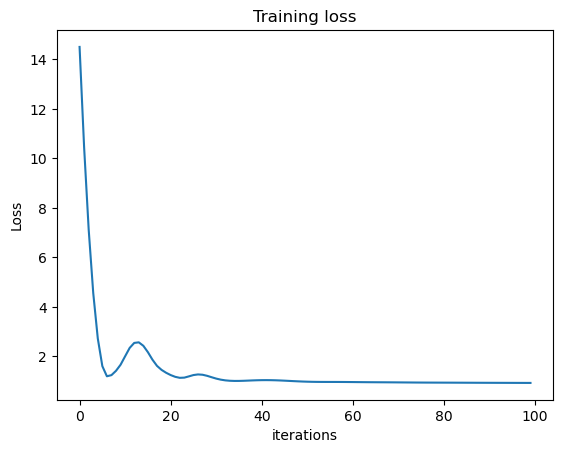

RMSE on model  MRI-ESM2-0  :  tensor(0.5608, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196028232574463
Epoch  6 , loss= 1.1878902912139893
Epoch  8 , loss= 1.413132905960083
Epoch  10 , loss= 2.001558780670166
Epoch  12 , loss= 2.542640447616577
Epoch  14 , loss= 2.4253900051116943
Epoch  16 , loss= 1.8628954887390137
Epoch  18 , loss= 1.4508651494979858
Epoch  20 , loss= 1.2412691116333008
Epoch  22 , loss= 1.1276953220367432
Epoch  24 , loss= 1.18354070186615
Epoch  26 , loss= 1.2658019065856934
Epoch  28 , loss= 1.2122721672058105
Epoch  30 , loss= 1.0984801054000854
Epoch  32 , loss= 1.025180459022522
Epoch  34 , loss= 1.001651406288147
Epoch  36 , loss= 1.0072286128997803
Epoch  38 , loss= 1.0220234394073486
Epoch  40 , loss= 1.0324747562408447
Epoch  42 , loss= 1.032151699066162
Epoch  44 , loss= 1.021119236946106
Epoch  46 , loss= 1.0037903785705566
Epoch  48 , loss= 0.9859124422073364
Epoch  50 , loss= 0.972

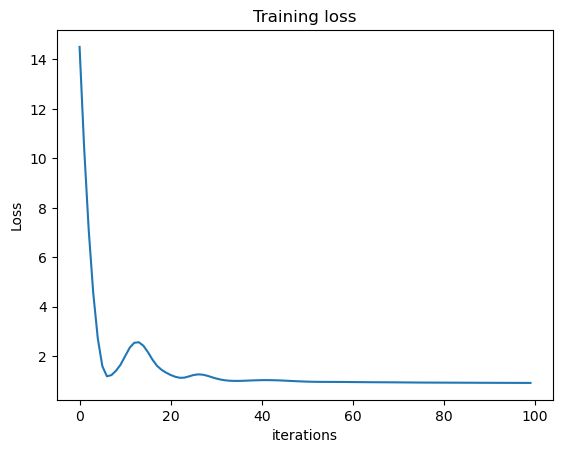

RMSE on model  CESM2-WACCM  :  tensor(0.6000, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1897140741348267
Epoch  8 , loss= 1.4123830795288086
Epoch  10 , loss= 1.9996620416641235
Epoch  12 , loss= 2.5404582023620605
Epoch  14 , loss= 2.4243106842041016
Epoch  16 , loss= 1.8631339073181152
Epoch  18 , loss= 1.4517784118652344
Epoch  20 , loss= 1.2423388957977295
Epoch  22 , loss= 1.1294528245925903
Epoch  24 , loss= 1.1859486103057861
Epoch  26 , loss= 1.2662776708602905
Epoch  28 , loss= 1.211643099784851
Epoch  30 , loss= 1.0986053943634033
Epoch  32 , loss= 1.0260939598083496
Epoch  34 , loss= 1.0028890371322632
Epoch  36 , loss= 1.0088355541229248
Epoch  38 , loss= 1.0240839719772339
Epoch  40 , loss= 1.034766435623169
Epoch  42 , loss= 1.0342658758163452
Epoch  44 , loss= 1.022800087928772
Epoch  46 , loss= 1.005065679550171
Epoch  48 , loss= 0.9869756102561951
Epoch  50 , loss=

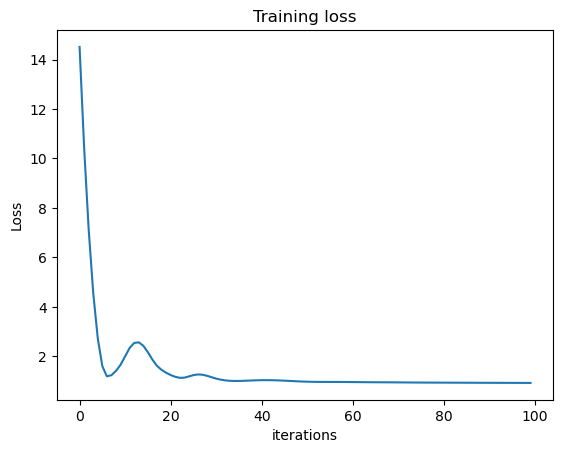

RMSE on model  ACCESS-ESM1-5  :  tensor(0.4787, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1908220052719116
Epoch  8 , loss= 1.413837194442749
Epoch  10 , loss= 1.999650239944458
Epoch  12 , loss= 2.540644884109497
Epoch  14 , loss= 2.4249486923217773
Epoch  16 , loss= 1.8640004396438599
Epoch  18 , loss= 1.4525254964828491
Epoch  20 , loss= 1.2429516315460205
Epoch  22 , loss= 1.12996506690979
Epoch  24 , loss= 1.1861753463745117
Epoch  26 , loss= 1.266646146774292
Epoch  28 , loss= 1.2123026847839355
Epoch  30 , loss= 1.0995752811431885
Epoch  32 , loss= 1.0273900032043457
Epoch  34 , loss= 1.0043158531188965
Epoch  36 , loss= 1.0101826190948486
Epoch  38 , loss= 1.02528977394104
Epoch  40 , loss= 1.0359044075012207
Epoch  42 , loss= 1.0354697704315186
Epoch  44 , loss= 1.0241665840148926
Epoch  46 , loss= 1.0065912008285522
Epoch  48 , loss= 0.9885663390159607
Epoch  50 , loss= 0

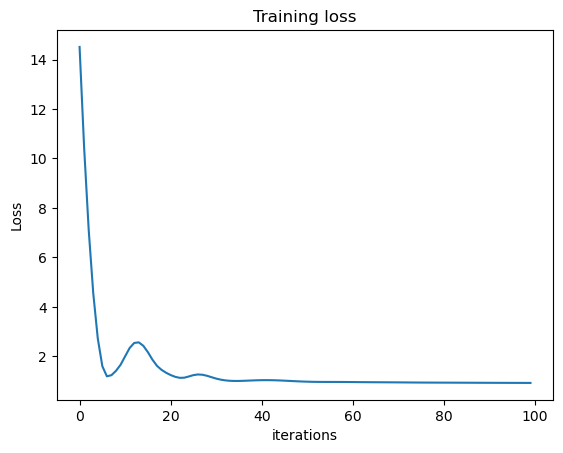

RMSE on model  IPSL-CM6A-LR  :  tensor(0.3861, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.719601631164551
Epoch  6 , loss= 1.186888337135315
Epoch  8 , loss= 1.4101635217666626
Epoch  10 , loss= 1.9975577592849731
Epoch  12 , loss= 2.5395596027374268
Epoch  14 , loss= 2.42084002494812
Epoch  16 , loss= 1.8569666147232056
Epoch  18 , loss= 1.4479575157165527
Epoch  20 , loss= 1.2403596639633179
Epoch  22 , loss= 1.1282644271850586
Epoch  24 , loss= 1.1847277879714966
Epoch  26 , loss= 1.2650190591812134
Epoch  28 , loss= 1.2108144760131836
Epoch  30 , loss= 1.0980151891708374
Epoch  32 , loss= 1.0251593589782715
Epoch  34 , loss= 1.0016165971755981
Epoch  36 , loss= 1.0074458122253418
Epoch  38 , loss= 1.0226653814315796
Epoch  40 , loss= 1.033286690711975
Epoch  42 , loss= 1.0326457023620605
Epoch  44 , loss= 1.0209952592849731
Epoch  46 , loss= 1.00312340259552
Epoch  48 , loss= 0.9850274324417114
Epoch  50 , loss= 0

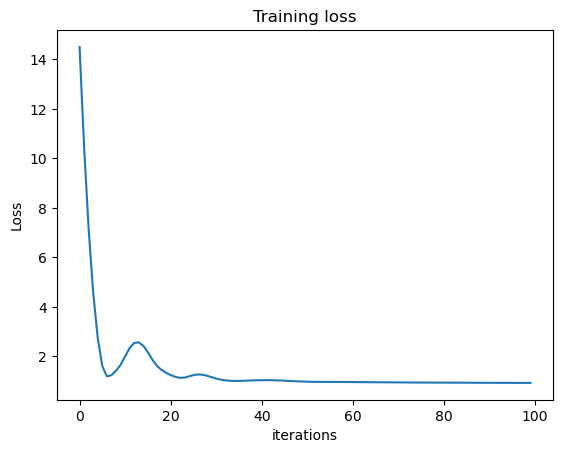

RMSE on model  CanESM5  :  tensor(0.5361, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1906942129135132
Epoch  8 , loss= 1.4108942747116089
Epoch  10 , loss= 1.9977784156799316
Epoch  12 , loss= 2.537564754486084
Epoch  14 , loss= 2.421872138977051
Epoch  16 , loss= 1.8614795207977295
Epoch  18 , loss= 1.4480839967727661
Epoch  20 , loss= 1.2389624118804932
Epoch  22 , loss= 1.12821626663208
Epoch  24 , loss= 1.186402678489685
Epoch  26 , loss= 1.2635635137557983
Epoch  28 , loss= 1.2070764303207397
Epoch  30 , loss= 1.0953118801116943
Epoch  32 , loss= 1.0245771408081055
Epoch  34 , loss= 1.0018619298934937
Epoch  36 , loss= 1.0076267719268799
Epoch  38 , loss= 1.022635817527771
Epoch  40 , loss= 1.0330232381820679
Epoch  42 , loss= 1.0321106910705566
Epoch  44 , loss= 1.020236849784851
Epoch  46 , loss= 1.0022270679473877
Epoch  48 , loss= 0.9839916229248047
Epoch  50 , loss= 0.9701

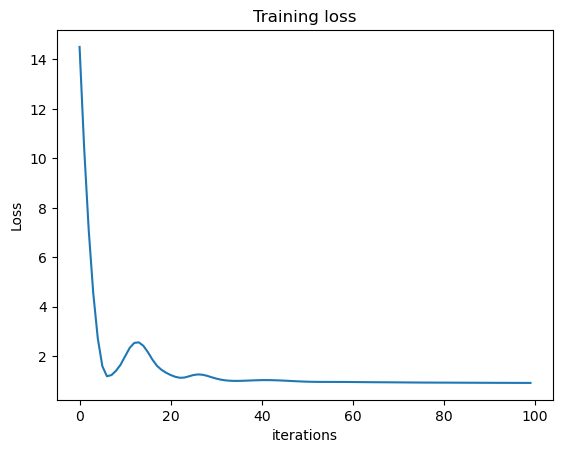

RMSE on model  ACCESS-CM2  :  tensor(0.5727, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.1906280517578125
Epoch  8 , loss= 1.4134336709976196
Epoch  10 , loss= 1.9999316930770874
Epoch  12 , loss= 2.540853261947632
Epoch  14 , loss= 2.4248554706573486
Epoch  16 , loss= 1.8636436462402344
Epoch  18 , loss= 1.4520385265350342
Epoch  20 , loss= 1.2424077987670898
Epoch  22 , loss= 1.1293991804122925
Epoch  24 , loss= 1.1859462261199951
Epoch  26 , loss= 1.2666242122650146
Epoch  28 , loss= 1.2121673822402954
Epoch  30 , loss= 1.0992295742034912
Epoch  32 , loss= 1.0269827842712402
Epoch  34 , loss= 1.0038787126541138
Epoch  36 , loss= 1.0096396207809448
Epoch  38 , loss= 1.024639368057251
Epoch  40 , loss= 1.0352563858032227
Epoch  42 , loss= 1.0349527597427368
Epoch  44 , loss= 1.0238285064697266
Epoch  46 , loss= 1.0063823461532593
Epoch  48 , loss= 0.9883829355239868
Epoch  50 , loss

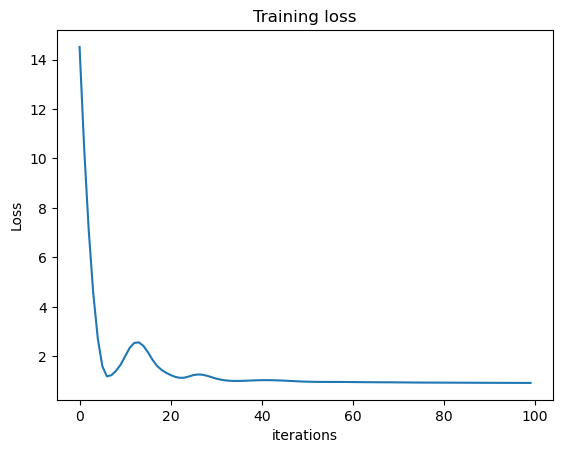

RMSE on model  MPI-ESM1-2-LR  :  tensor(0.4341, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.7196030616760254
Epoch  6 , loss= 1.190699577331543
Epoch  8 , loss= 1.4140738248825073
Epoch  10 , loss= 1.9998444318771362
Epoch  12 , loss= 2.5410046577453613
Epoch  14 , loss= 2.4251716136932373
Epoch  16 , loss= 1.8638384342193604
Epoch  18 , loss= 1.4521251916885376
Epoch  20 , loss= 1.2424834966659546
Epoch  22 , loss= 1.1292725801467896
Epoch  24 , loss= 1.1859544515609741
Epoch  26 , loss= 1.2665743827819824
Epoch  28 , loss= 1.2116061449050903
Epoch  30 , loss= 1.0983494520187378
Epoch  32 , loss= 1.0262607336044312
Epoch  34 , loss= 1.0035995244979858
Epoch  36 , loss= 1.0097819566726685
Epoch  38 , loss= 1.0249645709991455
Epoch  40 , loss= 1.035474419593811
Epoch  42 , loss= 1.0348693132400513
Epoch  44 , loss= 1.023409128189087
Epoch  46 , loss= 1.0057231187820435
Epoch  48 , loss= 0.9876484870910645
Epoch  50 , lo

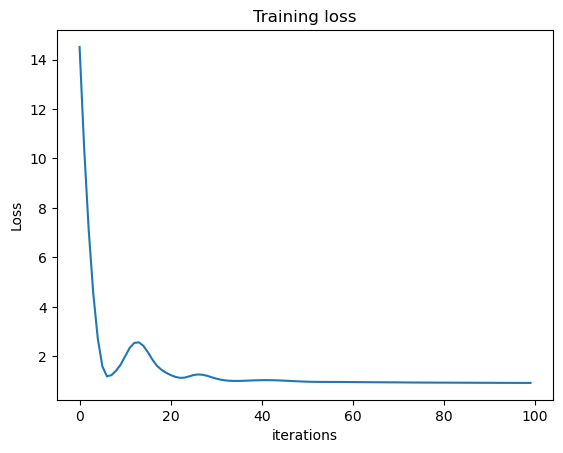

RMSE on model  FGOALS-f3-L  :  tensor(0.4775, dtype=torch.float64)
Epoch  0 , loss= 14.508557319641113
Epoch  2 , loss= 7.1245808601379395
Epoch  4 , loss= 2.71960186958313
Epoch  6 , loss= 1.186882495880127
Epoch  8 , loss= 1.411123275756836
Epoch  10 , loss= 1.997105360031128
Epoch  12 , loss= 2.53794527053833
Epoch  14 , loss= 2.421544075012207
Epoch  16 , loss= 1.8603248596191406
Epoch  18 , loss= 1.4498748779296875
Epoch  20 , loss= 1.2412554025650024
Epoch  22 , loss= 1.1284620761871338
Epoch  24 , loss= 1.1856268644332886
Epoch  26 , loss= 1.2633581161499023
Epoch  28 , loss= 1.2047414779663086
Epoch  30 , loss= 1.0881938934326172
Epoch  32 , loss= 1.0154385566711426
Epoch  34 , loss= 0.9949817061424255
Epoch  36 , loss= 1.0032185316085815
Epoch  38 , loss= 1.0189316272735596
Epoch  40 , loss= 1.0285636186599731
Epoch  42 , loss= 1.026296854019165
Epoch  44 , loss= 1.013139247894287
Epoch  46 , loss= 0.9942300915718079
Epoch  48 , loss= 0.9755311012268066
Epoch  50 , loss= 0.961

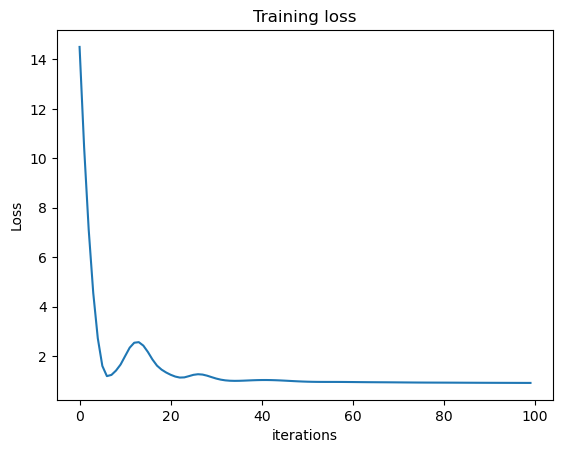

RMSE on model  UKESM1-0-LL  :  tensor(0.6964, dtype=torch.float64)
Check that the weights sum to 1.0  1.039802328310907


/tmp/ipykernel_21417/1106840682.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


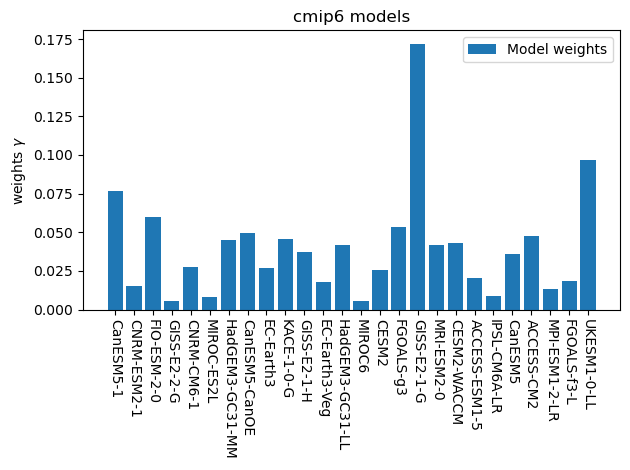

/tmp/ipykernel_21417/1106840682.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


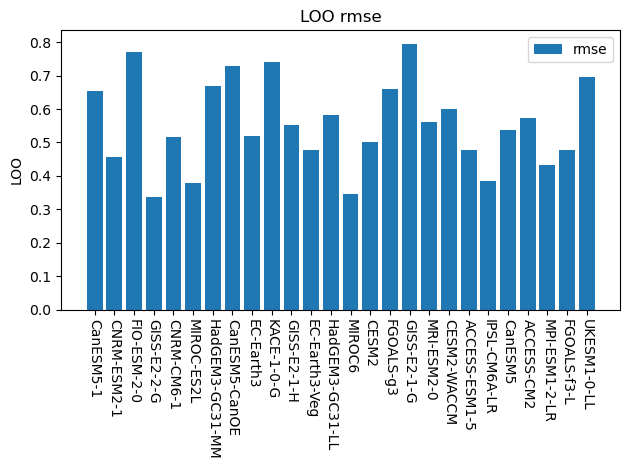

In [20]:
beta, rmse, weights = leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
                                                grid_lon_size,grid_lat_size,\
                                                lambda_=lambda_,method='robust',mu_=mu_,\
                                                nbEpochs=100,verbose=True)

In [21]:
rmse

{'CanESM5-1': tensor(0.6551, dtype=torch.float64),
 'CNRM-ESM2-1': tensor(0.4576, dtype=torch.float64),
 'FIO-ESM-2-0': tensor(0.7701, dtype=torch.float64),
 'GISS-E2-2-G': tensor(0.3372, dtype=torch.float64),
 'CNRM-CM6-1': tensor(0.5171, dtype=torch.float64),
 'MIROC-ES2L': tensor(0.3789, dtype=torch.float64),
 'HadGEM3-GC31-MM': tensor(0.6696, dtype=torch.float64),
 'CanESM5-CanOE': tensor(0.7293, dtype=torch.float64),
 'EC-Earth3': tensor(0.5199, dtype=torch.float64),
 'KACE-1-0-G': tensor(0.7413, dtype=torch.float64),
 'GISS-E2-1-H': tensor(0.5536, dtype=torch.float64),
 'EC-Earth3-Veg': tensor(0.4778, dtype=torch.float64),
 'HadGEM3-GC31-LL': tensor(0.5832, dtype=torch.float64),
 'MIROC6': tensor(0.3456, dtype=torch.float64),
 'CESM2': tensor(0.5006, dtype=torch.float64),
 'FGOALS-g3': tensor(0.6594, dtype=torch.float64),
 'GISS-E2-1-G': tensor(0.7959, dtype=torch.float64),
 'MRI-ESM2-0': tensor(0.5608, dtype=torch.float64),
 'CESM2-WACCM': tensor(0.6000, dtype=torch.float64),
 '

In [22]:
# compute the loo 
rmse_robust_tmp =  np.array(list(rmse.values()))

# worst loo
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)

# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)


# worst loo Ridge
worst_loo_ridge = np.max(rmse_robust_tmp)
mean_loo_ridge = np.mean(rmse_robust_tmp)

# quantiles for Ridge
q_loo_95_ridge = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_robust_tmp, 0.5)


print("======= Statistics ========")
print("\n")
print("          Robust Ridge")
print("0.95:     {:.3f}  {:.3f}".format(q_loo_95_robust,q_loo_95_ridge))
print("0.90:     {:.3f}  {:.3f}".format(q_loo_90_robust,q_loo_90_ridge))
print("0.75:     {:.3f}  {:.3f}".format(q_loo_75_robust,q_loo_75_ridge))
print("Median:   {:.3f}  {:.3f}".format(q_loo_50_robust,q_loo_50_ridge))
print("Mean:     {:.3f}  {:.3f}".format(mean_loo_robust,mean_loo_ridge))
print("Worst:    {:.3f}  {:.3f}".format(worst_loo_robust,worst_loo_ridge))

======= Statistics ========


          Robust Ridge
0.95:     0.763  0.763
0.90:     0.735  0.735
0.75:     0.658  0.658
Median:   0.545  0.545
Mean:     0.555  0.555
Worst:    0.796  0.796


In [23]:
rmse

{'CanESM5-1': tensor(0.6551, dtype=torch.float64),
 'CNRM-ESM2-1': tensor(0.4576, dtype=torch.float64),
 'FIO-ESM-2-0': tensor(0.7701, dtype=torch.float64),
 'GISS-E2-2-G': tensor(0.3372, dtype=torch.float64),
 'CNRM-CM6-1': tensor(0.5171, dtype=torch.float64),
 'MIROC-ES2L': tensor(0.3789, dtype=torch.float64),
 'HadGEM3-GC31-MM': tensor(0.6696, dtype=torch.float64),
 'CanESM5-CanOE': tensor(0.7293, dtype=torch.float64),
 'EC-Earth3': tensor(0.5199, dtype=torch.float64),
 'KACE-1-0-G': tensor(0.7413, dtype=torch.float64),
 'GISS-E2-1-H': tensor(0.5536, dtype=torch.float64),
 'EC-Earth3-Veg': tensor(0.4778, dtype=torch.float64),
 'HadGEM3-GC31-LL': tensor(0.5832, dtype=torch.float64),
 'MIROC6': tensor(0.3456, dtype=torch.float64),
 'CESM2': tensor(0.5006, dtype=torch.float64),
 'FGOALS-g3': tensor(0.6594, dtype=torch.float64),
 'GISS-E2-1-G': tensor(0.7959, dtype=torch.float64),
 'MRI-ESM2-0': tensor(0.5608, dtype=torch.float64),
 'CESM2-WACCM': tensor(0.6000, dtype=torch.float64),
 '

ValueError: `bins` must increase monotonically, when an array

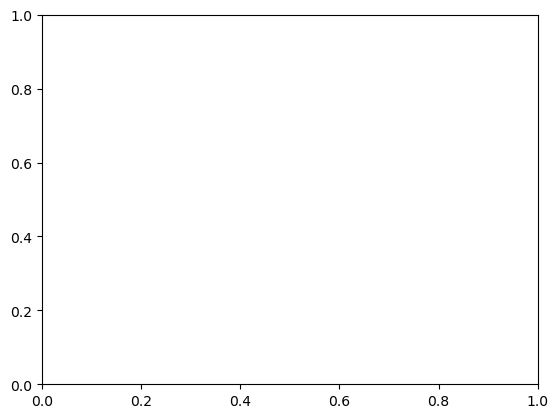

In [33]:
plt.figure()
plt.hist(range(len(rmse.keys())),list(rmse.values()))

In [24]:
# M = len(list(dic_reduced_ssp585.keys()))
# gamma = torch.zeros(M)
# res = torch.zeros(M,33)
# alpha_=0.1
# for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    
#     for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
#         res[idx_m,:] += (y_train[m][i] - torch.matmul(x_train[m][i],beta_tmp))**2/variance_processed_ssp585[m]
        
#     res[idx_m,:] = res[idx_m,:]/len(dic_reduced_ssp585[m].keys())

#     gamma[idx_m] = (1/alpha_)*torch.nanmean(res[idx_m,:],axis=0)


# gamma = torch.nn.functional.softmax(gamma,dim=0)


# # plot the model contributions
# fig, ax = plt.subplots()
# models = list(dic_reduced_ssp585.keys())
# weights = list(gamma.detach().numpy())

# ax.bar(models, weights,label='Model weights')
# ax.set_ylabel(r'weights $\gamma$')
# ax.set_ylim(0.0,0.8)
# ax.set_title('cmip6 models')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.show()

In [25]:
def cross_validation_loo(x,y,vars,lon_size,lat_size,lambda_range,method='robust',alpha_range=np.array([0.1,1.0,10.0]),nbEpochs=500,verbose=True):

    # create the pytorch tensor 
    beta = {}
    rmse = {}
    weights = {}
    y_pred = {}
    y_test = {}

    if method != 'robust':
        alpha_range_tmp = np.array([1.0])
    
    # for each pair (alpha, lambda) perform validation
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        # for each alpha:
        for idx_alpha, alpha_ in enumerate(alpha_range):

            print("Cross validation: (" + str(alpha_)+", "+ str(lambda_)+ ")")

            beta_tmp, rmse_tmp, weights_tmp = leave_one_out_procedure(x,y,vars,\
                                                                      lon_size,lat_size,\
                                                                      lambda_,method,alpha_,\
                                                                      nbEpochs=2,verbose=False)

            beta[(alpha_,lambda_)] = beta_tmp
            rmse[(alpha_,lambda_)] = rmse_tmp
            weights[(alpha_,lambda_)] = weights_tmp

    return beta, rmse, weights

In [26]:
# alpha_range = np.linspace(0.5, 1000, num=10)
# lambda_range = np.linspace(0.01, 1000, num=20)


alpha_range = np.array([0.5])
lambda_range = np.array([500.0])

# with open('alpha_range.npy', 'wb') as f:
#     np.save(f, alpha_range)

# with open('lambda_range.npy', 'wb') as f:
#     np.save(f, lambda_range)

# beta_robust, rmse_robust, weights_robust = cross_validation_loo(x_predictor,y_forced_response,variance_processed_ssp585,\
#                                                                 grid_lon_size,grid_lat_size,\
#                                                                 lambda_range,'robust',alpha_range,\
#                                                                 nbEpochs=2,verbose=True)

In [27]:
# leave_one_out_procedure(x_predictor,y_forced_response,variance_processed_ssp585,\
#               grid_lon_size,grid_lat_size,\
#               alpha_,lambda_,\
#               nbEpochs=1000,verbose=False)

# Sanity check

## All models vs Observations

In [28]:
# alpha_ = 0.5
# lambda_ = 50
# selected_models = list(dic_reduced_ssp585.keys())
# beta_robust = train_robust_model(x_train,y_train,variance_processed_ssp585,\
#                           grid_lat_size,grid_lat_size,\
#                           selected_models,alpha_,lambda_,nbEpochs=1000,verbose=True)

In [29]:
###### Compute residual ##########
sst_tmp = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp[np.abs(sst_tmp)> 1e20] = float('nan')
ytrue = np.nanmean(sst_tmp,axis=1)

# for each model, compute the predicted values 
sst_tmp_zeros = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp_zeros[np.abs(sst_tmp_zeros)> 1e20] = 0.0

In [30]:
ypred_robust = np.matmul(beta_robust,sst_tmp_zeros.T)
ypred_ridge = np.matmul(beta_ridge,sst_tmp_zeros.T)

rmse_real_robust = torch.mean((ypred_robust - ytrue)**2)
rmse_real_ridge = torch.mean((ypred_ridge - ytrue)**2)
print(rmse_real_robust)
print(rmse_real_ridge)

NameError: name 'beta_robust' is not defined

In [ ]:
# minx = np.min(y_obs)
# maxx = np.max(y_obs)
# x_tmp = np.linspace(minx,maxx,100)
# y_tmp = x_tmp


# fig, ax = plt.subplots()
# ax.scatter(y_obs,y_pred_softmax,label='robust')
# ax.plot(x_tmp,y_tmp)
# ax.set_xlabel('observations')
# ax.set_ylabel('predictions')
# ax.legend()
# plt.show()